## Курсовой проект

### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

### Метрика качества

F1-score (sklearn.metrics.f1_score)

### Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
Решение должно содержать

Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv

#### Импортируем библиотеки

In [40]:
import datetime
import os
import pickle
import shap

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgbm

import sklearn
import catboost as ctb

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, f1_score
from sklearn import metrics

from catboost import Pool, cv
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
from catboost.utils import select_threshold

#### Прописываем пути и загружаем данные

In [43]:
TRAIN_FILEPATH = 'course_project_train.csv'
TEST_FILEPATH = 'course_project_test.csv'
METRICS_FILEPATH = 'metrics.pkl'
TARGET = 'Credit Default'

In [44]:
raw_train_df = pd.read_csv(TRAIN_FILEPATH)
raw_test_df = pd.read_csv(TEST_FILEPATH)
raw_train_df.head().T

,0,1,2,3,4
Home Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual Income,482087,1.02549e+06,751412,805068,776264
Years in current job,NaN,10+ years,8 years,6 years,8 years
Tax Liens,0,0,0,0,0
Number of Open Accounts,11,15,11,8,13
Years of Credit History,26.3,15.3,35,22.5,13.6
Maximum Open Credit,685960,1.18173e+06,1.18243e+06,147400,385836
Number of Credit Problems,1,0,0,1,1
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1,0,0,1,0


In [45]:
raw_train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


#### Обрабатываем выбросы и генерируем новые признаки

Создаем необходимые функции

In [47]:
def metamorphosis(raw_df):
    
    # Make a copy of DataFrame
    df = raw_df.copy()
    
    
    # Some constants
    cred_score_median = df['Credit Score'].median()
    ann_inc_median = df['Annual Income'].median()
    wired_loan_amount = np.percentile(raw_train_df['Current Loan Amount'], 85)
    wired_open_credit = np.percentile(raw_train_df['Maximum Open Credit'], 99)
    
    
    # Converts types
    object_cols = df.select_dtypes(include='object').columns.tolist()
    float_cols = df.select_dtypes(include='float64').columns.tolist()

    df[object_cols] = df[object_cols].astype('category')
    df[float_cols] = df[float_cols].astype('float32')


    # Fill NaN section
    df['Annual Income'] = df['Annual Income'].fillna(ann_inc_median)
    df['Credit Score'] = df['Credit Score'].fillna(cred_score_median)
    df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
    df['Years in current job'] = df['Years in current job'].fillna('< 1 year')
    
    df = df.drop(columns=['Months since last delinquent'])
        
    # Maximum Open Credit
    df.loc[df['Maximum Open Credit'] > wired_open_credit * 2, 'Maximum Open Credit'] = wired_open_credit
    # Current Loan Amount (to del NaNs)
    df.loc[df['Current Loan Amount'] > wired_loan_amount * 2, 'Current Loan Amount'] = None
    
    if TARGET in df.columns.tolist():
        df.dropna(inplace=True)
        df[TARGET] = df[TARGET].astype('int8')        
        
    df['Current Loan Amount'].fillna(wired_loan_amount, inplace=True)
        
    df['Term'] = pd.Series(df['Term'].map({'Short Term': 0, 'Long Term': 1}), dtype=np.int8)
    # Years in current job
    job_years_dict = {'< 1 year': 0,
                      '1 year': 1,
                      '2 years': 2,
                      '3 years': 3,
                      '4 years': 4,
                      '5 years': 5,
                      '6 years': 6,
                      '7 years': 7,
                      '8 years': 8,
                      '9 years': 9,
                      '10+ years': 10}
    df['Years in current job'] = pd.Series(df['Years in current job'].map(job_years_dict), dtype=np.int8)
    
    df['No Tax Liens'] = (df['Tax Liens'] == 0)
    df['No Credit Problems'] = (df['Number of Credit Problems'] == 0)
    df['No Bankruptcies'] = (df['Bankruptcies'] == 0)

    df['Credit Score Cat'] = 0
    df.loc[(df['Credit Score'] >= 580) & (df['Credit Score'] < 670), 'Credit Score Cat'] = 1
    df.loc[(df['Credit Score'] >= 670) & (df['Credit Score'] < 730), 'Credit Score Cat'] = 2
    df.loc[(df['Credit Score'] >= 730) & (df['Credit Score'] < 735), 'Credit Score Cat'] = 3
    df.loc[(df['Credit Score'] >= 735) & (df['Credit Score'] < 755), 'Credit Score Cat'] = 4
    df.loc[df['Credit Score'] > 755, 'Credit Score Cat'] = -1
    
    
    # Makes dummies
    df = pd.get_dummies(df, drop_first=True)
    
    renew_prop = 'Purpose_renewable energy'
    if renew_prop not in df.columns.tolist():
        df[renew_prop] = 0
    
    int_columns = [
               'Annual Income',
               'Tax Liens',
               'Number of Open Accounts',
               'Maximum Open Credit',
               'Number of Credit Problems',
               'Bankruptcies',
               'Current Credit Balance',
               'Monthly Debt',
               'Credit Score']
    
    df[int_columns] = df[int_columns].astype('int32')

    
    return df

In [49]:
def heatmap(df):
    corr = df.corr()

    plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(10, 240, n=200),
        square=True
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.show()

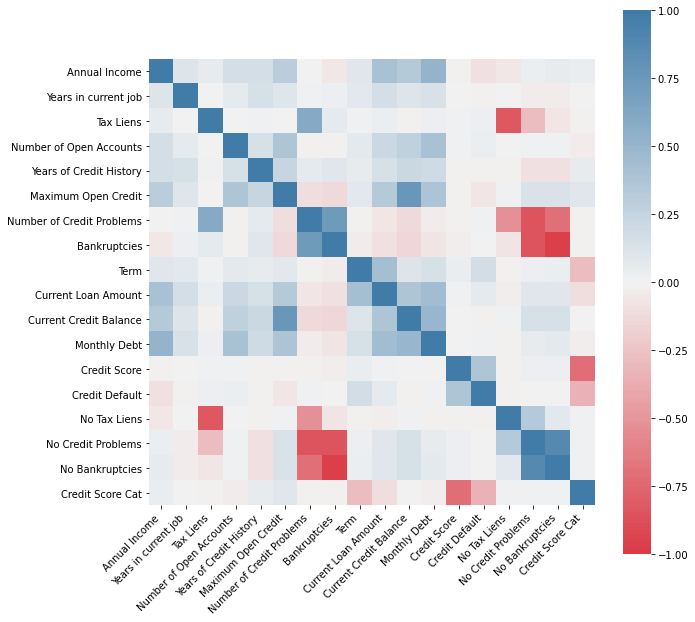

In [50]:
train_df = metamorphosis(raw_train_df)
test_df = metamorphosis(raw_test_df)

heatmap(train_df.select_dtypes(exclude='uint8'))

Влияние признаков на основные классы

Text(0.5, 1.0, 'Correlation with TARGET variable')

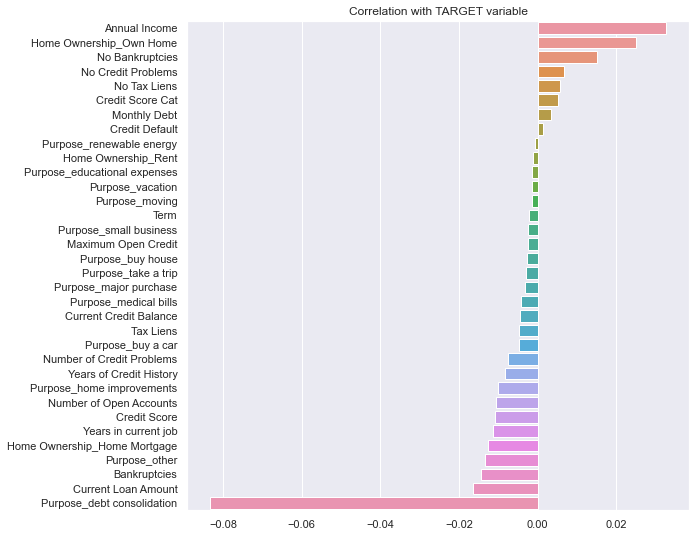

In [51]:
sns.set(font_scale=1)
corr_with_TARGET = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(9, 9))
sns.barplot(x=corr_with_TARGET.values, y=corr_with_TARGET.index)
plt.title('Correlation with TARGET variable')

Смотрим распределение кредита по величине выданных средств

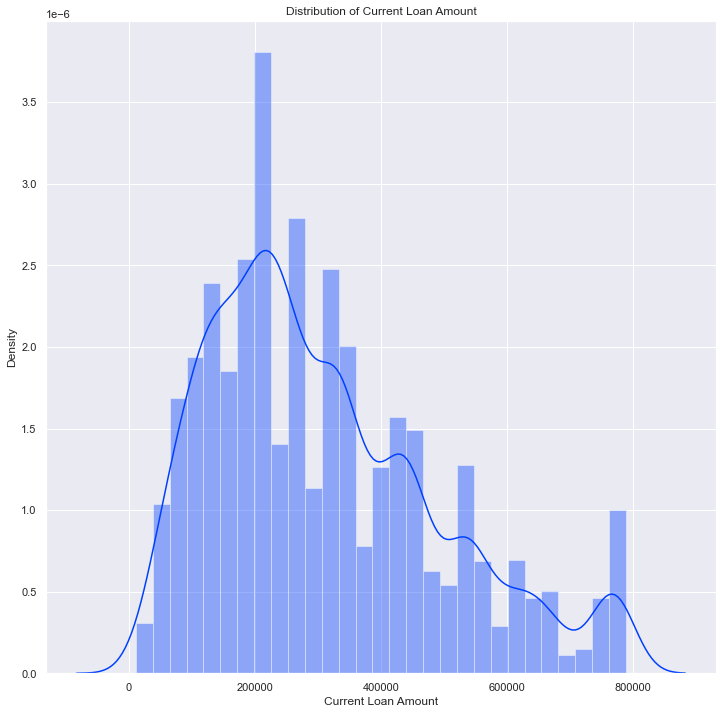

In [52]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(12,12))
sns.distplot(train_df['Current Loan Amount'])
plt.title('Distribution of Current Loan Amount')
plt.grid(True)

Создаём новый признак

In [53]:
pd.crosstab(train_df['Credit Default'], train_df['Credit Score Cat'])

Credit Score Cat,-1,1,2,3,4
Credit Default,,,,,
0,0,184,1552,1342,1439
1,400,144,627,635,307


## CatBoost

In [55]:
def get_cat_features(df):
    
    cat_features_list = []
    object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
       
    for cf in object_cols:
        cat_features_list.append(df.columns.get_loc(cf))
    
    return cat_features_list

In [56]:
X = train_df.drop(TARGET, axis=1)
y = train_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=42)

cat_features = get_cat_features(X)
cat_features

[]

In [57]:
y.value_counts()

0    4517
1    2113
Name: Credit Default, dtype: int64

Важность признаков

In [59]:
frozen_params = {'silent': True,
                 'random_state': 42,
                 'n_estimators': 1200,
                 'eval_metric': 'F1',
                 'custom_metric': 'Precision',
                 'learning_rate': 0.01,
                 'class_weights': [1, 2.2],
                 'early_stopping_rounds': 800
                }

In [65]:
cat_model = ctb.CatBoostClassifier(**frozen_params)

cat_model.fit(X_train, y_train, cat_features, eval_set=(X_test, y_test))

In [71]:
if os.path.exists(METRICS_FILEPATH):

    with open(METRICS_FILEPATH, 'rb') as file:
        pre_metrics = pickle.load(file)

else: pre_metrics = 'Previous metrics is not defined'

y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

metrics = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

with open(METRICS_FILEPATH, 'wb') as file:
    pickle.dump(metrics, file)

print('\n', (pre_metrics, "We've been here before, haven't we?")[pre_metrics == metrics])

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      3614
           1       0.67      0.68      0.68      1690

    accuracy                           0.79      5304
   macro avg       0.76      0.76      0.76      5304
weighted avg       0.79      0.79      0.79      5304

TEST

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       903
           1       0.54      0.54      0.54       423

    accuracy                           0.71      1326
   macro avg       0.66      0.66      0.66      1326
weighted avg       0.71      0.71      0.71      1326

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               708  195
1               194  229

 Previous metrics is not defined


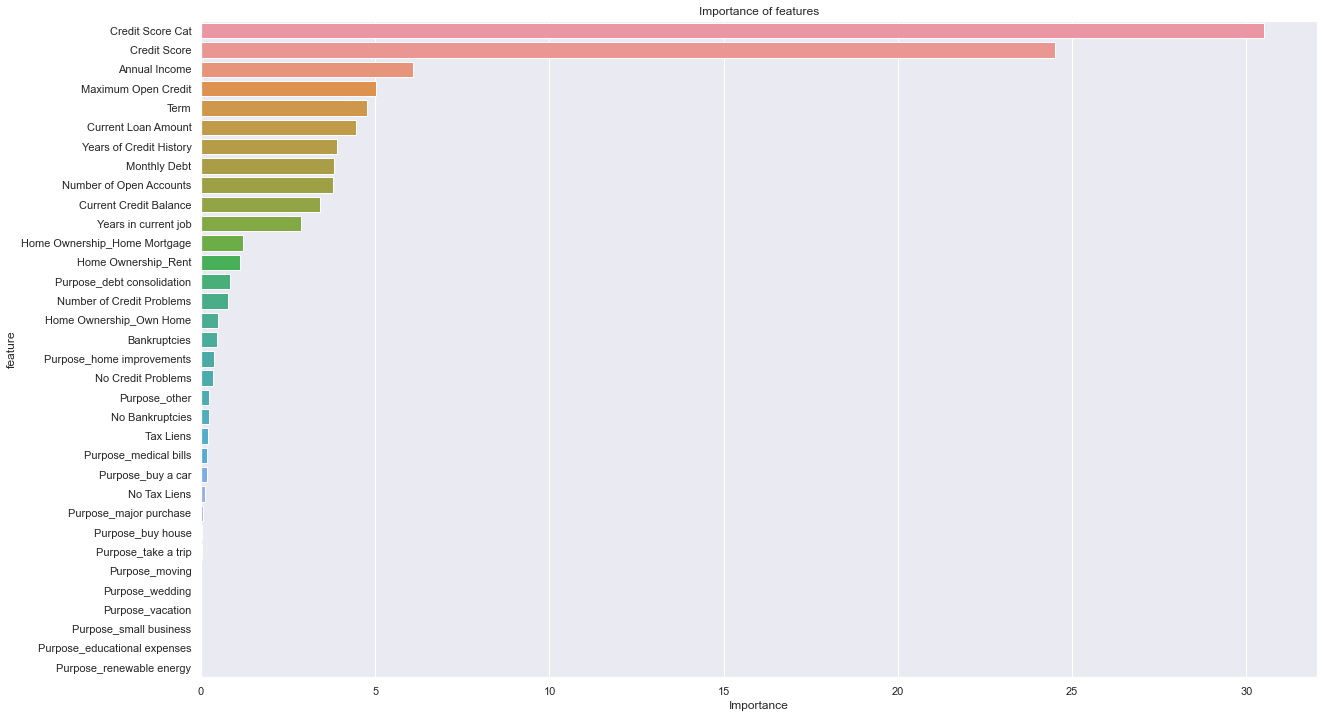

In [66]:
important_features_top = show_feature_importances(X.columns, cat_model.feature_importances_, get_top=15)

In [67]:
final_params = {'silent': True,
                 'random_state': 42,
                 'n_estimators': 800,
                 'eval_metric': 'F1',
                 'custom_metric': 'Precision',
                 'learning_rate': 0.01,
                 'class_weights': [1, 2.6],
                }

In [68]:
model = ctb.CatBoostClassifier(**final_params)

model.fit(X, y, cat_features)

In [76]:
test_predictions = model.predict(test_df)

submit = pd.read_csv('sampleSubmission.csv')
submit['Credit Default'] = test_predictions
submit.to_csv('BoydokAV_predictions.csv', index=False)
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
